In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
#loads the dataset if you input:directory
def load_dataset(folder):
    images = []
    y=[]
    limit=0
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            temp=filename.split(".")
            y.append(int(temp[0][-1]))
    return np.array(images),np.array(y)

class neural_network_class:
    def __init__(self,layers,X,Y):
        self.X=X #input 
        self.Y=Y  #classes
        self.m=X.shape[1] #shape of X
        self.y_n=len(np.unique(Y)) #no of classes
        self.no_of_layers=len(layers) # no of layers
        self.parameters={}  #stores W,b,Z,A
        self.d={}   #stores partial derivatives
        self.parameters["A0"]=X #X input can be considered as A0
        layers.append(self.y_n) #appending last layer
        self.costs=[]
        self.accuracy=[]
        
        #initialising the parameters weights bias,activation for l layers
        

        for l in range(0,len(layers)-1):
            self.parameters["W"+str(l+1)]=np.random.randn(layers[l+1],layers[l])*0.01
            self.parameters["b"+str(l+1)]=np.zeros((layers[l+1],1))
            self.parameters["Z"+str(l+1)]=None
            self.parameters["A"+str(l+1)]=None
        
        #initialising dZ,dW,db,dA values for l layers
        for l in range(0,len(layers)-1):
            self.d["Z"+str(l+1)]=None
            self.d["W"+str(l+1)]=None
            self.d["b"+str(l+1)]=None
            
    #soft max_function
    #exp(Z1)/sum(exp(Z1))
    def softmax(self):
        A=self.parameters["Z"+str(self.no_of_layers)]
        return np.exp(A)/np.sum(np.exp(A),axis=0,keepdims=True)
    
    
    #one hat encoding
    #example [0,1,2]
    #ouput 
    #[1,0,0]
    #[0,1,0]
    #[0,0,1]
    
    def one_hat_encode(self,Y):
        y_h=np.zeros((Y.shape[0],self.y_n))
        for i in range(0,X.shape[1]):
            y_h[i][Y[i]]=1
        self.y_h=y_h.T

            
    def feedforward(self):
        for l in range(0,self.no_of_layers-1):
            W,b=self.parameters["W"+str(l+1)],self.parameters["b"+str(l+1)]
            A_prev=self.parameters["A"+str(l)]
            Z=np.dot(W,A_prev)+b
            self.parameters["Z"+str(l+1)]=Z
            self.parameters["A"+str(l+1)]=self.Activation(Z,"sigmoid")
        
        #soft max layer
        W,b=self.parameters["W"+str(self.no_of_layers)],self.parameters["b"+str(self.no_of_layers)]
        Aprev=self.parameters["A"+str(self.no_of_layers-1)]
        self.parameters["Z"+str(self.no_of_layers)]=np.dot(W,Aprev)+b
        self.parameters["A"+str(self.no_of_layers)]=self.softmax()
        
    #activation function       
    def Activation(self,Z,arg):
        if arg=="sigmoid":
            return 1/(1+np.exp(-Z))
        if arg=="relu":
            return np.maximum(0,Z)
        
    #calucualate the loss
    #sigma sigma -plogq multi class cross entropy 
    def cost(self):
        A=self.softmax()
        self.loss=(-1/self.m)*np.sum(np.multiply(self.y_h,np.log(A)))
        return self.loss
    
    # dervative of sigmoid g(x)(1-g(x))
    def gx(self,x):
        return np.multiply(x,1-x)
        
    #back propagation step
    def backprop(self):
        l=self.no_of_layers
        P = self.parameters["A"+str(l)]
        A_prev=self.parameters["A"+str(l-1)]
        
        #softmax layer
        #partial derivate cost fun
        #predicted P probabities from softmax
        #y_h ground truth
        dZ = (1/self.m)*(P- self.y_h)
        dW=np.dot(dZ,A_prev.T)
        db=np.sum(dZ,axis=1,keepdims=True)
        
        self.d["Z"+str(l)]=dZ
        self.d["W"+str(l)]=dW
        self.d["b"+str(l)]=db
        
        for i in range(0,l-1):
            
            A_prev =   self.parameters["A"+str(l-i-1)]
            W      =  self.parameters["W"+str(l-i)]
            dZ_prev=  self.d["Z"+str(l-i)]
            
            
            dZ     =  np.multiply(np.dot(W.T,dZ_prev),self.gx(A_prev))
            A      =  self.parameters["A"+str(l-i-2)]
            dW     =  np.dot(dZ,A.T)
            db     =  np.sum(dZ,axis=1,keepdims=True)
            #print(dZ)
            self.d["Z"+str(l-i-1)]=dZ
            self.d["W"+str(l-i-1)]=dW
            self.d["b"+str(l-i-1)]=db
            
    #update weights
    #W=W-n*dW
    #b=b-n*db
    def upgrade(self):
        for l in range(0,self.no_of_layers):
            self.parameters["W"+str(l+1)]=self.parameters["W"+str(l+1)]-0.4*self.d["W"+str(l+1)]
            self.parameters["b"+str(l+1)]=self.parameters["b"+str(l+1)]-0.4*self.d["b"+str(l+1)]
        
    #train the model
    def train(self,epochs):
        for i in range(0,epochs):
            self.feedforward()
            self.backprop()
            self.upgrade()
            self.costs.append(self.cost())
            self.accuracy.append(self.Accuracy(False))
            if (i+1)%100==0:
                print("cycle no = " ,(i)%99+1,"/",epochs/100)
                print("no of iterations completed = ",i+1,",cost = ",self.cost())
        
    #caluculates the accuracy 
    def Accuracy(self,output):
        i=0
        acc=0
        prob=self.parameters["A"+str(self.no_of_layers)].T
        for val in self.y_h.T:
            if np.argmax(val)==np.argmax(prob[i]):
                acc=acc+1
            i=i+1
        if output:
            print()
            print("------------------------------------------->")
            print("Total no of correctly classifed =",acc,"/",i)
            print("Total no of wrongly classifed =",i-acc,"/",i)
            print("Accurcy = ",acc/i*100)
            print("------------------------------------------->")
            print()
        else:
            return acc*100/i
        
    
    def test_dataset(self,X,Y):
        self.parameters["A0"]=X
        self.one_hat_encode(Y)
        self.feedforward()
        self.Accuracy(True)
        
    
    def predict_class(self,X,Y):
        self.parameters["A0"]=X
        self.one_hat_encode(Y)
        self.feedforward()
        prob=self.parameters["A"+str(self.no_of_layers)].T
        label=np.argmax(prob)
        if label==0:
            print("It is Apple")
        elif label==1:
            print("It is  Banana")
        elif label==2:
            print("It is Orange")
        elif label==3:
            print("It is  Rotten Apple")
        elif label==4:
            print("It is Rotten Banana")
        elif label==5:
            print("It is Rotten Orange")
        
            
    
    #y_n no of classes
    #y true 
    #x predicted
    def confusion_matrix(self):
        self.conf_mat = np.zeros((self.y_n,self.y_n))
        prob=self.parameters["A"+str(self.no_of_layers)].T
        i=0
        for val in self.y_h.T:
            y=np.argmax(val)
            x=np.argmax(prob[i])
            self.conf_mat[y][x]=self.conf_mat[y][x]+1
            i=i+1
        print("Confusion matrix")
        print(self.conf_mat)
    
    def Graph_Plot(self):
        print("Cost vs Accuracy")
        plt.plot([x for x in range(1,len(self.accuracy)+1)],self.accuracy)
        plt.legend(["Accuracy"]) 
        plt.plot([x for x in range(1,len(self.costs)+1)],self.costs)
        plt.legend(["Cost"]) 
        plt.show()
    
    #precision,recall,Fscore
    def metrics(self):
        mat=self.conf_mat
        TP_FP     =    np.sum(mat,axis=1,keepdims=True)
        TP_FN     =    np.sum(mat,axis=0,keepdims=True)
        Precision =    np.divide(np.diagonal(mat),TP_FP)
        Recall    =    np.divide(np.diagonal(mat),TP_FN)
        F_score   =    2*(Precision*Recall)/(Precision+Recall)
        
        print()
        for i in range(0,self.y_n):
            print("Precision of (class =",i,") =",Precision[0][i])
            print("Recall    of (class =",i,") =",Recall[0][i])
            print("F_score   of (class =",i,") =",F_score[0][i])
            print()
            
    





cycle no =  1 / 17.0
no of iterations completed =  100 ,cost =  1.7713594495472882
cycle no =  2 / 17.0
no of iterations completed =  200 ,cost =  1.6634284439977551
cycle no =  3 / 17.0
no of iterations completed =  300 ,cost =  1.312661081789628
cycle no =  4 / 17.0
no of iterations completed =  400 ,cost =  1.1225636218232342
cycle no =  5 / 17.0
no of iterations completed =  500 ,cost =  1.0792792605808765
cycle no =  6 / 17.0
no of iterations completed =  600 ,cost =  1.0620813749703495
cycle no =  7 / 17.0
no of iterations completed =  700 ,cost =  0.9573433487714966
cycle no =  8 / 17.0
no of iterations completed =  800 ,cost =  0.8684722506534811
cycle no =  9 / 17.0
no of iterations completed =  900 ,cost =  0.8780550593425439
cycle no =  10 / 17.0
no of iterations completed =  1000 ,cost =  0.7600496669013181
cycle no =  11 / 17.0
no of iterations completed =  1100 ,cost =  0.6696518586257239
cycle no =  12 / 17.0
no of iterations completed =  1200 ,cost =  0.6261275637246182

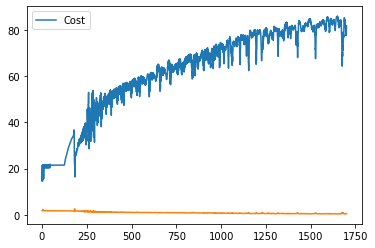


------------------------------------------->
Total no of correctly classifed = 2165 / 2698
Total no of wrongly classifed = 533 / 2698
Accurcy =  80.24462564862861
------------------------------------------->

Confusion matrix
[[354.   9.   0.  30.   0.   2.]
 [ 23. 343.   0.   3.   9.   3.]
 [  6.   5. 295.  68.   3.  11.]
 [113.   1.  12. 434.  25.  16.]
 [  2.   2.   0.   6. 508.  12.]
 [ 10.   4.  24.  92.  42. 231.]]

Precision of (class = 0 ) = 0.8962025316455696
Recall    of (class = 0 ) = 0.6968503937007874
F_score   of (class = 0 ) = 0.7840531561461793

Precision of (class = 1 ) = 0.8683544303797468
Recall    of (class = 1 ) = 0.9423076923076923
F_score   of (class = 1 ) = 0.9038208168642952

Precision of (class = 2 ) = 0.7468354430379747
Recall    of (class = 2 ) = 0.8912386706948641
F_score   of (class = 2 ) = 0.8126721763085399

Precision of (class = 3 ) = 1.09873417721519
Recall    of (class = 3 ) = 0.6856240126382307
F_score   of (class = 3 ) = 0.8443579766536966

Precisi

In [2]:
#load train dataset
X,y=load_dataset("/home/shanky/btp/datset/final_train")
Y=np.array(y)
X_flatten = X.reshape(X.shape[0], -1).T
X=X_flatten/255     

        
#you can add no of layers and no of nodes in each layer
layers=[X.shape[0],250,150]
network=neural_network_class(layers,X,Y)
network.one_hat_encode(Y)
network.train(1700)
network.Accuracy(True)
network.confusion_matrix()
network.metrics()
network.Graph_Plot()

#load test dataset
X,y=load_dataset("/home/shanky/btp/datset/final_test")
Y=np.array(y)
X_flatten = X.reshape(X.shape[0], -1).T
X=X_flatten/255
network.test_dataset(X,Y)
network.confusion_matrix()
network.metrics()

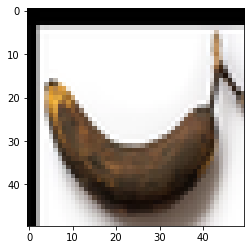

It is Rotten Banana


In [3]:
import matplotlib.image as mpimg
def select(folder,number):
    images = []
    y=[]
    i=1
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
           
            temp=filename.split(".")
            if i==number:
                y.append(int(temp[0][-1]))
                images.append(img)
                image = mpimg.imread(os.path.join(folder,filename))
                plt.imshow(image)
                plt.show()
                return np.array(images),np.array(y)
            
        i=i+1
#select photo
X,y=select("/home/shanky/btp/datset/final_test",10)
Y=np.array(y)
X_flatten = X.reshape(X.shape[0], -1).T
X=X_flatten/255
network.predict_class(X,Y)


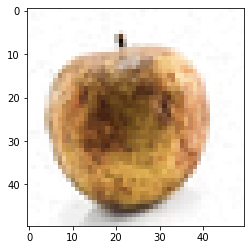

It is  Rotten Apple


In [62]:
import matplotlib.image as mpimg

def select(folder,number):
    images = []
    y=[]
    i=1
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
           
            temp=filename.split(".")
            if i==number:
                y.append(int(temp[0][-1]))
                images.append(img)
                image = mpimg.imread(os.path.join(folder,filename))
                plt.imshow(image)
                plt.show()
                return np.array(images),np.array(y)
            
        i=i+1
#select photo
X,y=select("/home/shanky/btp/datset/final_test",709)
Y=np.array(y)
X_flatten = X.reshape(X.shape[0], -1).T
X=X_flatten/255
network.predict_class(X,Y)








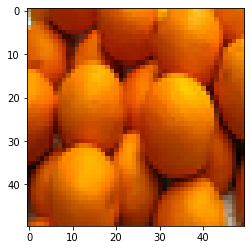

It is Orange


In [43]:
import matplotlib.image as mpimg

def select(folder,number):
    images = []
    y=[]
    i=1
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            temp=filename.split(".")
            if i==number:
                image = mpimg.imread(os.path.join(folder,filename))
                plt.imshow(image)
                plt.show()
                y.append(int(temp[0][-1]))
                images.append(img)
                return np.array(images),np.array(y)
        i=i+1
#select photo
X,y=select("/home/shanky/btp/datset/real_test",6)
Y=np.array(y)
X_flatten = X.reshape(X.shape[0], -1).T
X=X_flatten/255
network.predict_class(X,Y)


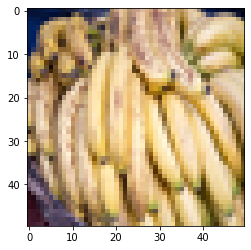

It is  Banana


In [44]:
import matplotlib.image as mpimg

def select(folder,number):
    images = []
    y=[]
    i=1
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            temp=filename.split(".")
            if i==number:
                image = mpimg.imread(os.path.join(folder,filename))
                plt.imshow(image)
                plt.show()
                y.append(int(temp[0][-1]))
                images.append(img)
                return np.array(images),np.array(y)
        i=i+1
#select photo
X,y=select("/home/shanky/btp/datset/real_test",2)
Y=np.array(y)
X_flatten = X.reshape(X.shape[0], -1).T
X=X_flatten/255
network.predict_class(X,Y)


Cost vs Accuracy


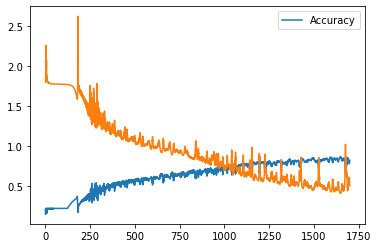

In [7]:
print("Cost vs Accuracy")
plt.plot([x for x in range(1,len(network.accuracy)+1)],np.divide(network.accuracy,100))
plt.plot([x for x in range(1,len(network.costs)+1)],network.costs)
plt.legend(["Accuracy"])
plt.show()

2